In [13]:
# Avoid interference with GDAL from other external software due to environment variables used: GDAL_DATA and PROJ_LIB

import os
import getpass

usuario = getpass.getuser()

# os.environ['GDAL_DATA'] = f'/opt/anaconda3/envs/geoenv/share/gdal'
# os.environ['PROJ_LIB'] = f'/opt/anaconda3/envs/geoenv/share'

# en windows, NECESARIO EN AULA y seguramente en equipos con la misma instalación y SO
os.environ['GDAL_DATA'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\gdal'
os.environ['PROJ_LIB'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\share\\proj'
os.environ['PATH'] = f'C:\\Users\\{usuario}\\anaconda3\\envs\\advprog\\Library\\bin'

In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray
import shapely
import sys
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import CRS
import contextily as ctx

In [15]:
sys.argv[1] = "C:\\Users\\angel\\Documents\\Programacion_avanzada\\practicas\\Geodatos\\"

In [24]:
eucal_cant = gpd.read_file(sys.argv[1] + "eucal_cant.shp")
cantabria = gpd.read_file(sys.argv[1] + "shp_cantabria\\cantabria.shp")
euc_mfe_cant = gpd.read_file(sys.argv[1] + "Eucaliptales_Cornisa_Cantabrica\\Eucaliptales_Cornisa_Cantabrica.shp")

In [30]:
cantabria = cantabria.to_crs(eucal_cant.crs)
euc_mfe_cant = euc_mfe_cant[euc_mfe_cant["NUT3_NOM"] == "Cantabria"]

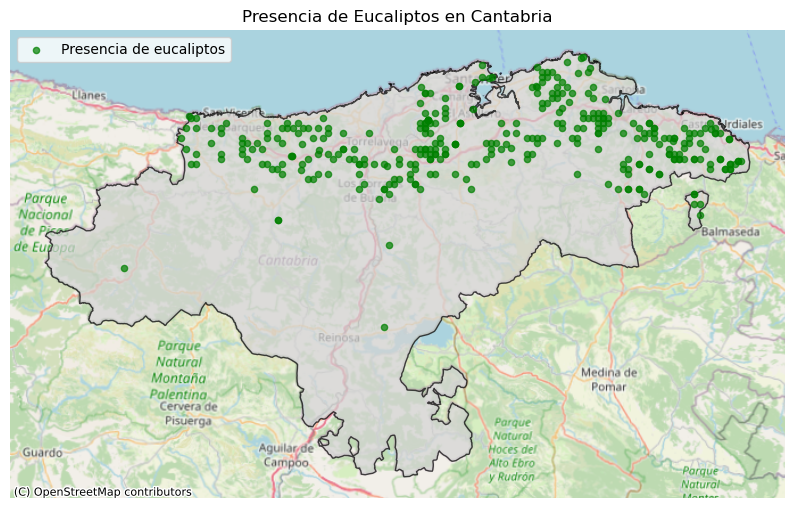

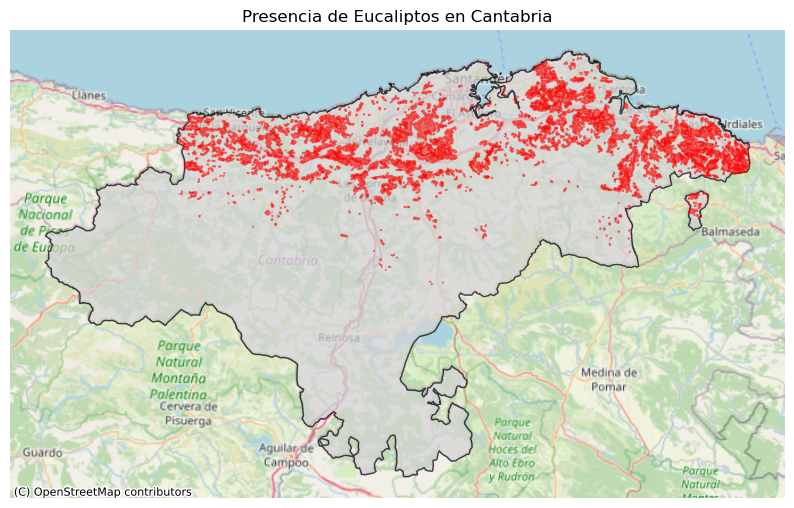

In [33]:
# Crear la figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar límites de Cantabria
cantabria.plot(ax=ax, edgecolor='black', color='lightgray', alpha=0.7)

# Dibujar puntos de presencia de eucaliptos
eucal_cant.plot(ax=ax, marker='o', color='green', markersize=20, alpha=0.7, label='Presencia de eucaliptos')

# Añadir fondo de mapa
ctx.add_basemap(ax, crs=cantabria.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Mejorar el diseño
plt.title("Presencia de Eucaliptos en Cantabria")
plt.legend()

# Quitar ejes
ax.set_axis_off()

# Mostrar el mapa
plt.show()

# Crear la figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar límites de Cantabria
cantabria.plot(ax=ax, edgecolor='black', color='lightgray', alpha=0.7)

# Dibujar polígonos de eucaliptos
euc_mfe_cant.plot(ax=ax, edgecolor='red', color='red', alpha=0.5, label='Zonas de eucaliptos')

# Añadir fondo de mapa
ctx.add_basemap(ax, crs=cantabria.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Mejorar el diseño
plt.title("Presencia de Eucaliptos en Cantabria")

# Quitar ejes
ax.set_axis_off()

# Mostrar el mapa
plt.show()


In [38]:
municipios = gpd.read_file(sys.argv[1] + "Municipios\\Municipios_IGN.shp")
municipios = municipios.to_crs(eucal_cant.crs)
municipios.crs

C:\Users\angel\anaconda3\envs\advprog\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\angel\Documents\Programacion_avanzada\practicas\Geodatos\Municipios\Municipios_IGN.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


<Projected CRS: EPSG:25830>
Name: ETRS89 / UTM zone 30N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 6°W and 0°W: Faroe Islands offshore; Ireland - offshore; Jan Mayen - offshore; Norway including Svalbard - offshore; Spain - mainland - onshore and offshore.
- bounds: (-6.0, 35.26, 0.01, 80.49)
Coordinate Operation:
- name: UTM zone 30N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [44]:
municipios_cantabria = gpd.overlay(municipios, cantabria, how='intersection')


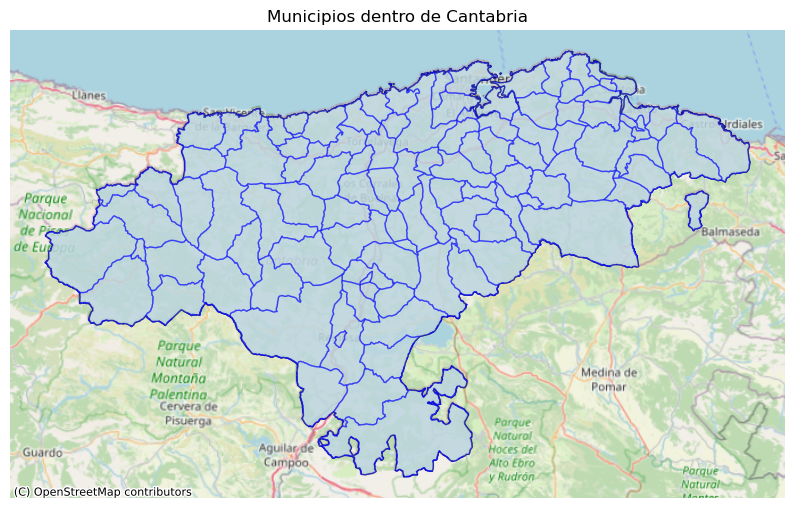

In [46]:
# Mostrar el resultado
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar límites de Cantabria
cantabria.plot(ax=ax, edgecolor='black', color='lightgray', alpha=0.7)

# Dibujar municipios dentro de Cantabria
municipios_cantabria.plot(ax=ax, edgecolor='blue', color='lightblue', alpha=0.5, label="Municipios en Cantabria")

# Añadir fondo de mapa
import contextily as ctx
ctx.add_basemap(ax, crs=cantabria.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Mejorar diseño
plt.title("Municipios dentro de Cantabria")
ax.set_axis_off()

plt.show()

C:\Users\angel\AppData\Local\Temp\ipykernel_8724\2610578329.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  municipios_eucaliptos.to_file(sys.argv[1] + "Municipios\\Municipios_Eucaliptos.shp")
C:\Users\angel\anaconda3\envs\advprog\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'INSPIREID_1' to 'INSPIREID_'
  ogr_write(
C:\Users\angel\anaconda3\envs\advprog\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'INSPIREID_2' to 'INSPIREI_1'
  ogr_write(


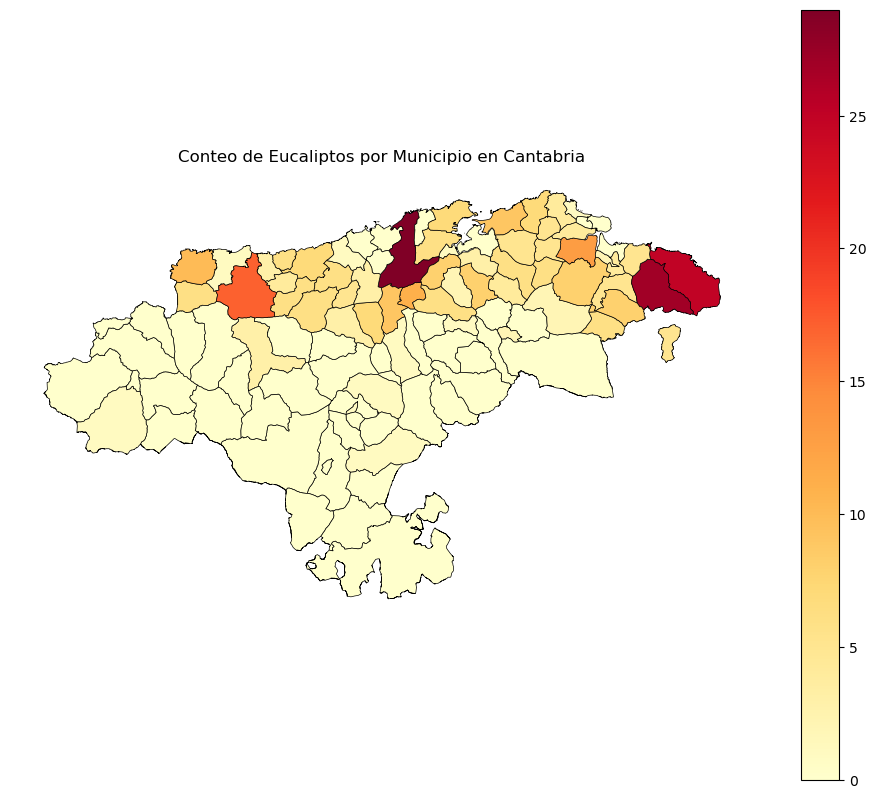

In [51]:
# Hacer una unión espacial para asignar cada punto a su municipio
joined = gpd.sjoin(eucal_cant, municipios_cantabria, how="inner", predicate="within")

# Contar el número de puntos por municipio
conteo = joined.groupby("index_right").size().reset_index(name="euc_count")

# Añadir el conteo a la tabla de municipios
municipios_eucaliptos = municipios_cantabria.join(conteo.set_index("index_right"))

# Rellenar con 0 los municipios sin eucaliptos (si es necesario)
municipios_eucaliptos["euc_count"] = municipios_eucaliptos["euc_count"].fillna(0).astype(int)

# Guardar el resultado en un nuevo shapefile
municipios_eucaliptos.to_file(sys.argv[1] + "Municipios\\Municipios_Eucaliptos.shp")

# Mostrar el resultado
fig, ax = plt.subplots(figsize=(12, 10))

# Dibujar municipios coloreando por el número de eucaliptos
municipios_eucaliptos.plot(
    column="euc_count",
    cmap="YlOrRd",
    edgecolor="black",
    linewidth=0.5,
    legend=True,
    ax=ax
)

# Añadir título y mejorar diseño
plt.title("Conteo de Eucaliptos por Municipio en Cantabria")
ax.set_axis_off()

plt.show()
